### Investigating dihedral twisting and Ir-N$_\mathrm{distal}$ dynamics in 2014 and 2021 Simulations

The npy files can be obtained here: https://www.dropbox.com/s/3lrmvqwhlzw7rg5/npys.zip?dl=0
The 2014 es npy is here: https://www.dropbox.com/s/ol3u33t3cmr6k6l/apos_ird_acn_2014_es.npy?dl=0  

`apos`: Aligned positions. Dimensions:  (#Frame, #Atom, xyz) for GS, and (#Frame, #Atom, xyz, #trajectory) for ES  
`s_:`: Scattering. Dimensions: For GS: (q, #frame). For ES: (q, #frame, #trajectory). `qvec = np.arange(0.00, 15, 0.05)`  
`ptp`: PtPOP  
`ird`: IrDimen  
`h2o` or `acn`: Whether the solvent was H2O or Acetonitrile (in the case of PtPOP). The positions and scattering is only is far only from the solutes.   
`d3` or `nod3`: For IrDimen. Indicates whether or not Grimme's D3 dispersion correction was used. When its on, the GS IrDimen conformer sampled is the short and twisted, when it's off, its the long and eclipsed.  

###### We will look at excitations from the long-eclipsed conformer, meaning we will compare 2014 and 2021-noD3 data
Both in ACN solvent

Trajectory info:  
2014: 3500 steps, 1 fs timestep, 41 trajectories total  
2021: 2001 steps, 2 fs timestep, 49 trajectories total


The 2014 simulations is of the 2:2-trans isomer, while the 2021 is on the most prevalent 3:1 isomer (half of synthesis yield):
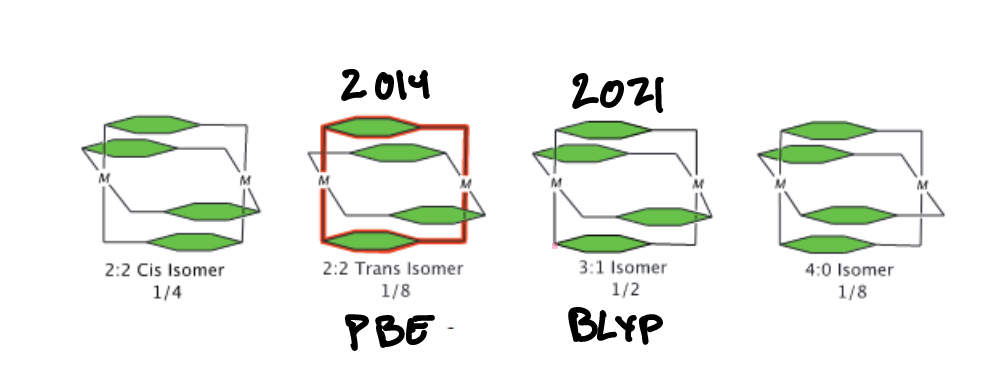  

All indices can be found in '2014.xyz' and '2021.xyz' (only use for the indices, the geometries are simply 2 random frames), but here is an overview of the most important ones:  
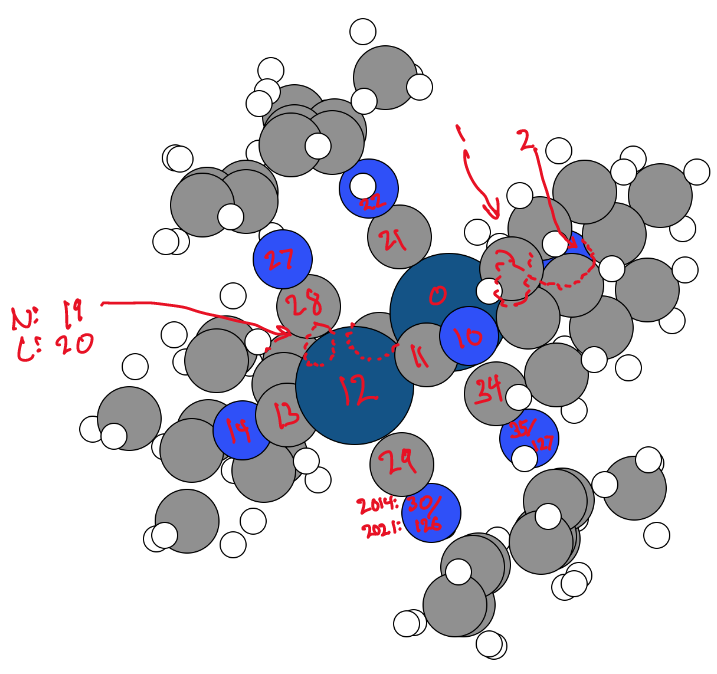

First, load stuff

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
matplotlib.rc('axes.formatter', limits= (-2, 2))
plt.rcParams.update({'font.size': 14})
import numpy as np

Define function that calculates the dihedral angle. Quick and dirty, no positive and negative direction defined. 
This is NOT the same definition as used in the 2014 paper.

But we aren't really interested direction anyways (are we?). Maybe for S2?? Hmm..  

In [2]:
def dihedral(tpos):
    ''' Get dihedral from arrays shaped (steps, #atoms, xyz, #trajectories)
    '''
    v11 = tpos[0, :, :] - tpos[1, :, :]
    v12 = tpos[2, :, :] - tpos[1, :, :]

    v21 = tpos[3, :, :] - tpos[2, :, :]
    v22 = tpos[1, :, :] - tpos[2, :, :]

    n1 = np.cross(v12, v11)
    n1 /= np.linalg.norm(n1, axis=1)[:, None]

    n2 = np.cross(v21, v22)
    n2 /= np.linalg.norm(n2, axis=1)[:, None]

    dih = np.degrees(np.arctan2(np.linalg.norm(np.cross(n1, n2), axis=1), (n1*n2).sum(1)))
    
    return dih

Load data

In [4]:
apos_ird_acn_2014_es = np.load('apos_ird_acn_2014_es.npy')
apos_ird_acn_nod3_es = np.load('apos_ird_acn_nod3_es.npy')

### Plot 2014 data
Using the ((Ir, N), (Ir, Ir)), ((Ir, Ir), (Ir, N)) vectors to span the two planes. The 2014 atomic indices are:
        
```
#        N, Ir, Ir, N
idxs = [[27, 12, 0, 22], 
        [10, 12, 0, 2],
        [30, 12, 0, 35],
        [14, 12, 0, 19]]
```


We can span 4 dihedral angles, $\phi$ per step. We plot the difference in dihedral angle wrt. the angle at the first step of the trajectory, $\phi(t) - \phi(0)$.

<IPython.core.display.Javascript object>


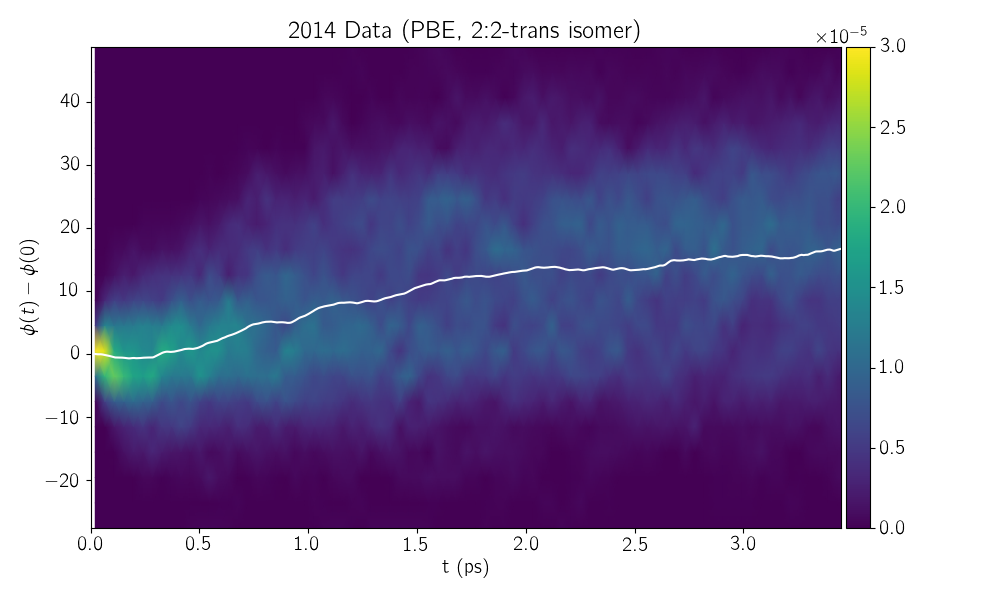

In [29]:
alldih = np.zeros((3500, 4, 41))
idxs = [[27, 12, 0, 22], 
        [10, 12, 0, 2],
        [30, 12, 0, 35],
        [14, 12, 0, 19]]

for i in range(41):
    for j in range(4):
        tpos = apos_ird_acn_2014_es[:, idxs[j], :, i]
        dih = dihedral(tpos)
        alldih[:, j, i] = dih - dih[0]
        
time = np.arange(0, alldih.shape[0])  # 1 fs timestep

ntrajs = alldih.shape[2]
mesh = np.tile(time, ntrajs * 4)  # 4 dihedrals per step
H, x, y  = np.histogram2d(mesh, 
                          alldih.T.flatten(),
                          bins=(80, 20),  
                          density=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
dx = x[1] - x[0]
dy = y[1] - y[0]

pcm = ax.pcolormesh((x[1:] - dx*0.5) /1e3 , y[1:]- dy*0.5, H.T, 
                    rasterized=True, shading='gouraud', vmax=3e-5)
fig.colorbar(pcm, ax=ax, pad=0.005)
ax.plot(time /1e3, np.mean(alldih, axis=(1,2)), 'w')
ax.set_xlabel('t (ps)')
ax.set_ylabel('$\phi(t) - \phi(0)$')
ax.set_xlim([0.0, 3.45])
ax.set_title('2014 Data (PBE, 2:2-trans isomer)')
fig.tight_layout()


### Plot 2014 data
Using the ((Ir, N), (Ir, Ir)), ((Ir, Ir), (Ir, N)) vectors to span the two planes. The 2014 atomic indices are:
        
```
#        N, Ir, Ir, N
idxs = [[27, 12, 0, 22], 
        [10, 12, 0, 2],
        [126, 12, 0, 127],
        [14, 12, 0, 19]]
```

So, almost the same but not quite..


<IPython.core.display.Javascript object>


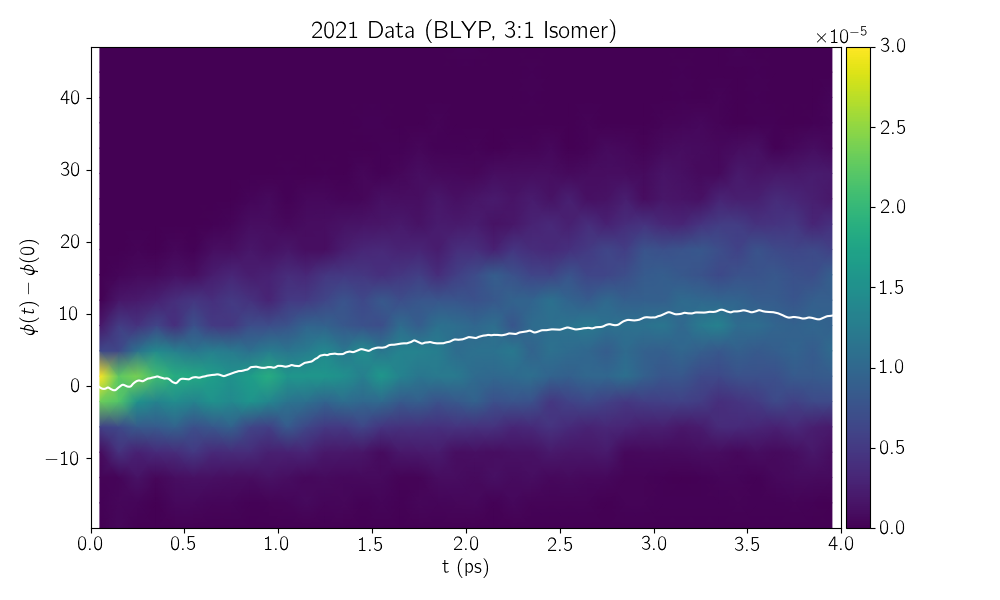

In [30]:
alldih = np.zeros((2001, 4, 49))
for i in range(49):
    for j in range(4):
        tpos = apos_ird_acn_nod3_es[:, idxs[j], :, i]
        dih = dihedral(tpos)
        alldih[:, j, i] = dih - dih[0]

time = np.arange(0, alldih.shape[0]) * 2  # 2 fs timestep

ntrajs = alldih.shape[2]
mesh = np.tile(time, ntrajs * 4)
H, x, y  = np.histogram2d(mesh, 
                          alldih.T.flatten(),
                          bins=(40, 20),  
                          density=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
dx = x[1] - x[0]
dy = y[1] - y[0]

pcm = ax.pcolormesh((x[1:] - dx*0.5) /1e3 , y[1:]- dy*0.5, H.T,
                    rasterized=True, shading='gouraud', vmax=3e-5)
fig.colorbar(pcm, ax=ax, pad=0.005)
ax.plot(time /1e3, np.mean(alldih, axis=(2, 1)), 'w')
ax.set_xlabel('t (ps)')
ax.set_ylabel('$\phi(t) - \phi(0)$')
ax.set_xlim([0.0, 4.0])
ax.set_title('2021 Data (BLYP, 3:1 Isomer)')
fig.tight_layout()     

The BLYP-predicted twist is smaller than for PBE. There's the same amount of rings in the ligands, they're just ordered differently, I am not sure how that should change the rigidity of the ligand scaffold this much.. So best bet is that it's due to the functional. 

In any case, both sets of trajectories show this slow increase in twist, which couuuld share the same kind of time-scale as the one identified in the inverted signal:
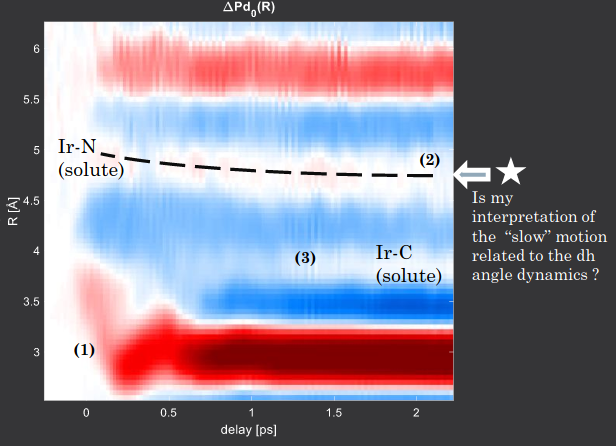


We can also just plot the direct Ir-N$_\mathrm{distal}$ distances. lets do so on top of the Ir-Ir distance:

<IPython.core.display.Javascript object>


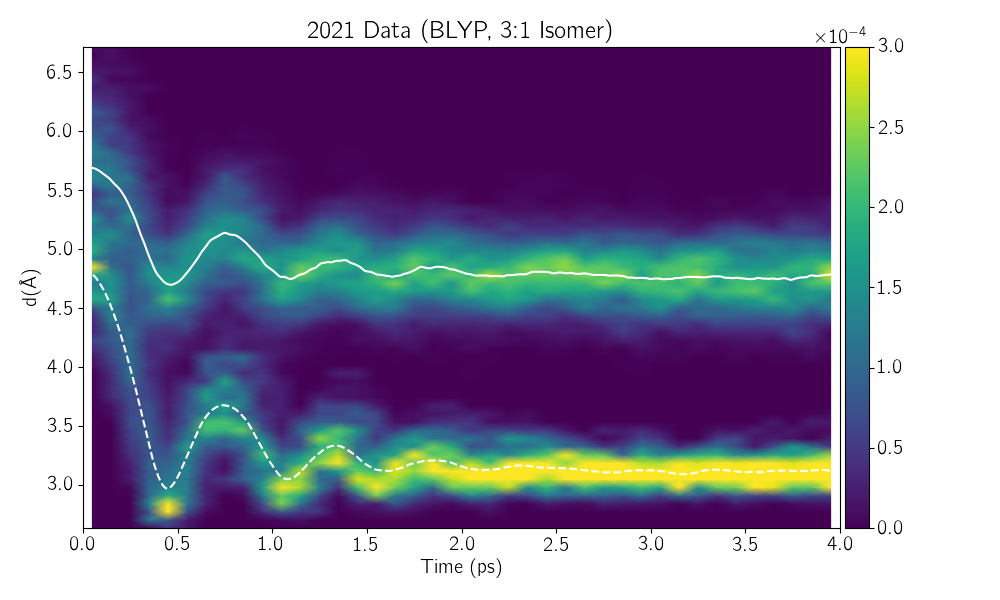

In [34]:
idxs = [[[0],  [27, 10, 126, 14]], 
        [[12], [22, 2,  127, 19]]]

dists = np.linalg.norm(apos_ird_acn_nod3_es[:, 0, :, :][:,None] - 
                       apos_ird_acn_nod3_es[:, idxs[0][1], :, :], axis=2)

dIrIr = np.linalg.norm(apos_ird_acn_nod3_es[:, 0, :, :] - 
                       apos_ird_acn_nod3_es[:, 12, :, :], axis=1)

evthing = np.concatenate((dists, dIrIr[:, None]), axis=1)
evthing = np.concatenate((evthing, dIrIr[:, None]), axis=1)
evthing = np.concatenate((evthing, dIrIr[:, None]), axis=1)
evthing = np.concatenate((evthing, dIrIr[:, None]), axis=1)

time = np.arange(0, dists.shape[0]) * 2  # 1 fs timestep

ntrajs = dists.shape[2]
mesh = np.tile(time, ntrajs * 8)
H, x, y  = np.histogram2d(mesh, 
                          evthing.T.flatten(),
                          bins=(40, 60),  # 160 bins of 4 ps total = 25 fs time bins
                          density=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
dx = x[1] - x[0]
dy = y[1] - y[0]

pcm = ax.pcolormesh((x[1:] - dx*0.5) /1e3 , y[1:]- dy*0.5, H.T, rasterized=True, shading='gouraud', vmax=3e-4)
fig.colorbar(pcm, ax=ax, pad=0.005)




ax.plot(time /1e3, np.mean(dists, axis=(2, 1)), 'w')
ax.plot(time /1e3, np.mean(dIrIr, axis=1), 'w--')

ax.set_xlabel('Time (ps)')
ax.set_ylabel('d(Å)')
ax.set_xlim([0, 4])
ax.set_title('2021 Data (BLYP, 3:1 Isomer)')
fig.tight_layout()       

The Ir-Ir distance starts out at ~4.7 Å which is ~0.4 longer than the experimental result, which means that the Ir-N$_\mathrm{distal}$ distances are _also_ too long.. Subtracting 0.4 Å would put the Ir-N$_\mathrm{distal}$ contraction pretty close to the results from the inverted scattering? 